# Модель предсказания оттока сотрудников компании

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.
Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли.
У вас будет несколько задач. Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.
Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.
Ваша вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.
Теперь расскажем подробнее о задачах.

## Задача 1: предсказание уровня удовлетворённости сотрудника

## Описание данных

Для этой задачи заказчик предоставил данные с признаками:

- `id` — уникальный идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.

## Загрузка данных

In [ ]:
!pip install --upgrade scikit-learn -q

In [ ]:
!pip install phik

In [ ]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import (
OneHotEncoder,
OrdinalEncoder,
StandardScaler,
MinMaxScaler,
PolynomialFeatures,
LabelEncoder)
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.inspection import permutation_importance

import time
import warnings
import phik

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
df_train_job = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv', sep=',')
df_test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv', sep=',')
df_test_target_job = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv', sep=',')

In [ ]:
df_train_job.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [ ]:
df_test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [ ]:
df_test_target_job.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [ ]:
df_train_job.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [ ]:
df_test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [ ]:
df_test_target_job.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


**Промежуточный вывод:**
Три датасета:
- `df_train_job` (4000 строк, 10 столбцов)
- `df_test_features` (2000 строк, 9 столбца)
- `df_test_target_job` (2000 строк, 2 столбца)

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:  </b>
    
С данными познакомились, проведен первичный аналитический осмотр!) Полученная информация поможет нам в дальнейшем с предобработкой данных

## Предобработка данных

In [ ]:
df_train_job['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [ ]:
df_test_features['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [ ]:
df_train_job = df_train_job.replace({'sinior': 'senior'})

In [ ]:
df_test_features = df_test_features.replace({'sinior': 'senior'})

In [ ]:
def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = -5, legend = False, fontsize = 16)
            .set_title('Пропуски' + "\n", fontsize = 22, color = 'SteelBlue')
        );
    except:
        print('Пропусков нет')

In [ ]:
df_train_job.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

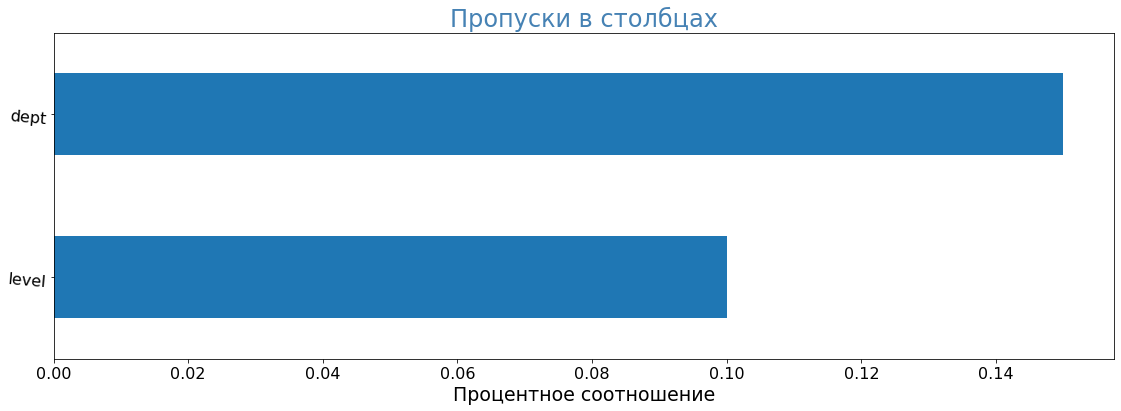

In [ ]:
pass_value_barh(df_train_job)
plt.xlabel('Процентное соотношение', fontsize=19)
plt.title('Пропуски в столбцах', fontsize=24)
plt.show();

In [ ]:
df_test_features.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

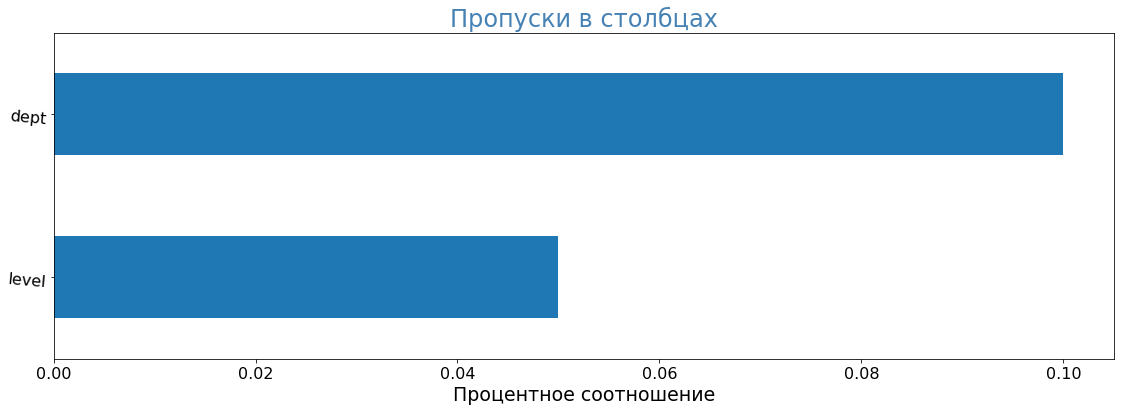

In [ ]:
pass_value_barh(df_test_features)
plt.xlabel('Процентное соотношение', fontsize=19)
plt.title('Пропуски в столбцах', fontsize=24)
plt.show();

In [ ]:
df_test_target_job.isna().sum()

id                       0
job_satisfaction_rate    0
dtype: int64

In [ ]:
print('Количество дубликатов равно', df_train_job.drop('id', axis=1).duplicated().sum())

Количество дубликатов равно 245


In [ ]:
 df_train_job = df_train_job.drop('id', axis=1).drop_duplicates()

**Соединим два датафрейма `df_test_features` и `df_test_target_job`:**

In [ ]:
df_test_features = pd.merge(df_test_features, df_test_target_job, on='id')

Пропущенные значения мы заполним потом, в пайплайне, тем более их не так много

## Исследовательский анализ данных

In [ ]:
df_train_job.describe()

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,3755.000000,3755.000000,3755.000000,3755.000000
mean,3.817044,3.463648,34457.416778,0.532554
std,2.557142,1.026265,15050.643870,0.226393
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.350000
50%,3.000000,4.000000,31200.000000,0.550000
75%,6.000000,4.000000,44400.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000


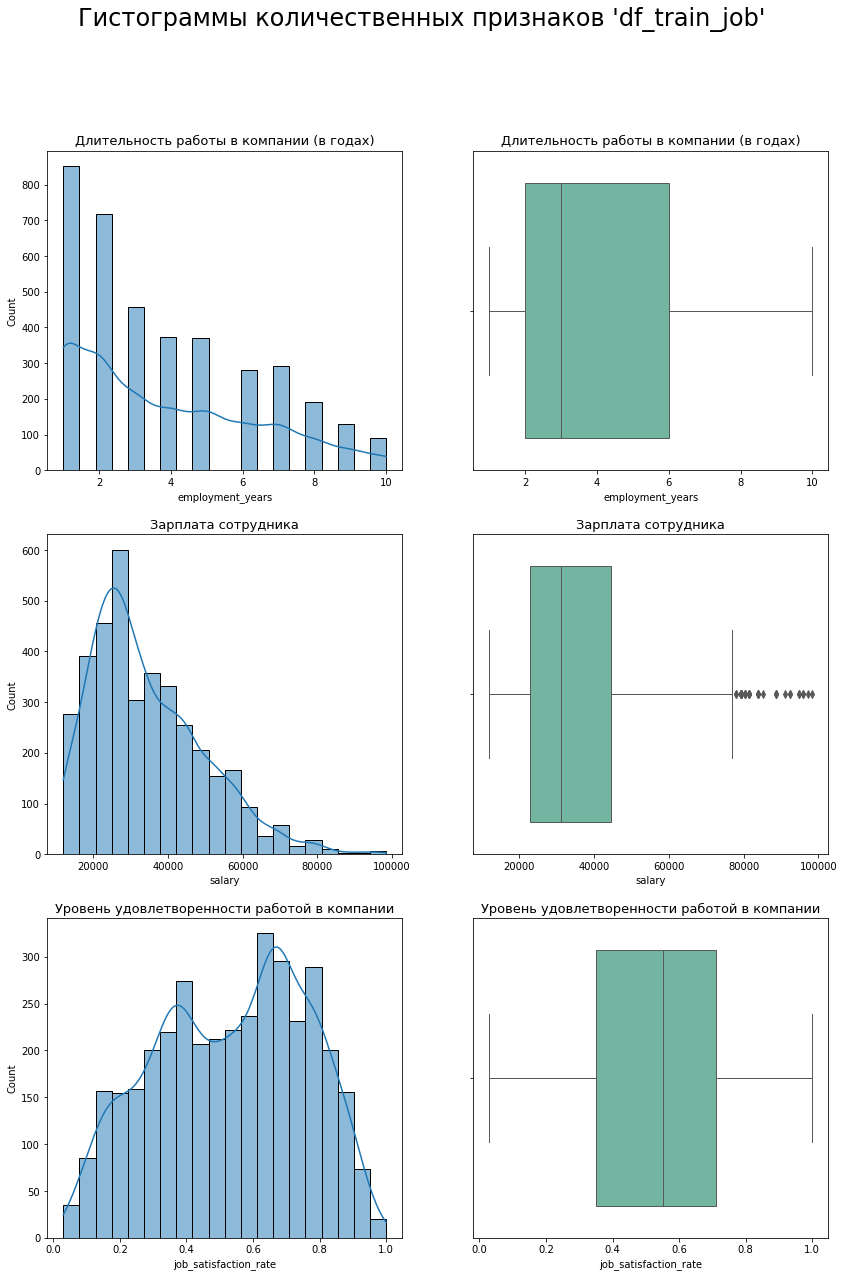

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(14, 20))

plt.suptitle('Гистограммы количественных признаков \'df_train_job\' ', fontsize=24)

axs[0][0].set_title('Длительность работы в компании (в годах)', fontsize=13)
sns.histplot(data=df_train_job, x='employment_years', ax=axs[0][0], kde=True, bins=20)

sns.boxplot(df_train_job['employment_years'], ax=axs[0][1], linewidth=1, palette='Set2', orient='h')
axs[0][1].set_title('Длительность работы в компании (в годах)', fontsize=13)

axs[1][0].set_title('Зарплата сотрудника', fontsize=13)
sns.histplot(data=df_train_job, x='salary', ax=axs[1][0], kde=True, bins=20)

sns.boxplot(df_train_job['salary'], ax=axs[1][1], linewidth=1, palette='Set2', orient='h')
axs[1][1].set_title('Зарплата сотрудника', fontsize=13)

axs[2][0].set_title('Уровень удовлетворенности работой в компании', fontsize=13)
sns.histplot(data=df_train_job, x='job_satisfaction_rate', ax=axs[2][0], kde=True, bins=20)

sns.boxplot(df_train_job['job_satisfaction_rate'], ax=axs[2][1], linewidth=1, palette='Set2', orient='h')
axs[2][1].set_title('Уровень удовлетворенности работой в компании', fontsize=13)

plt.show();

Посчитаем выбросы у `salary`

In [ ]:
Q1 = df_train_job['salary'].quantile(.25)
Q3 = df_train_job['salary'].quantile(.75)
IQR = Q3 - Q1

In [ ]:
(1-(df_train_job.query('salary < @Q3+1.5*@IQR and salary > @Q1-1.5*@IQR')['salary'].count()) / df_train_job['salary'].count()) * 100

1.331557922769644

1.5 % немного. Удалим

In [ ]:
df_train_job = df_train_job.query('salary < @Q3+1.5*@IQR and salary > @Q1-1.5*@IQR')

Так как оценка качества работы сотрудника - это ранговый признак, удалять выбросы там не будем.

Теперь построим графики для категориальных

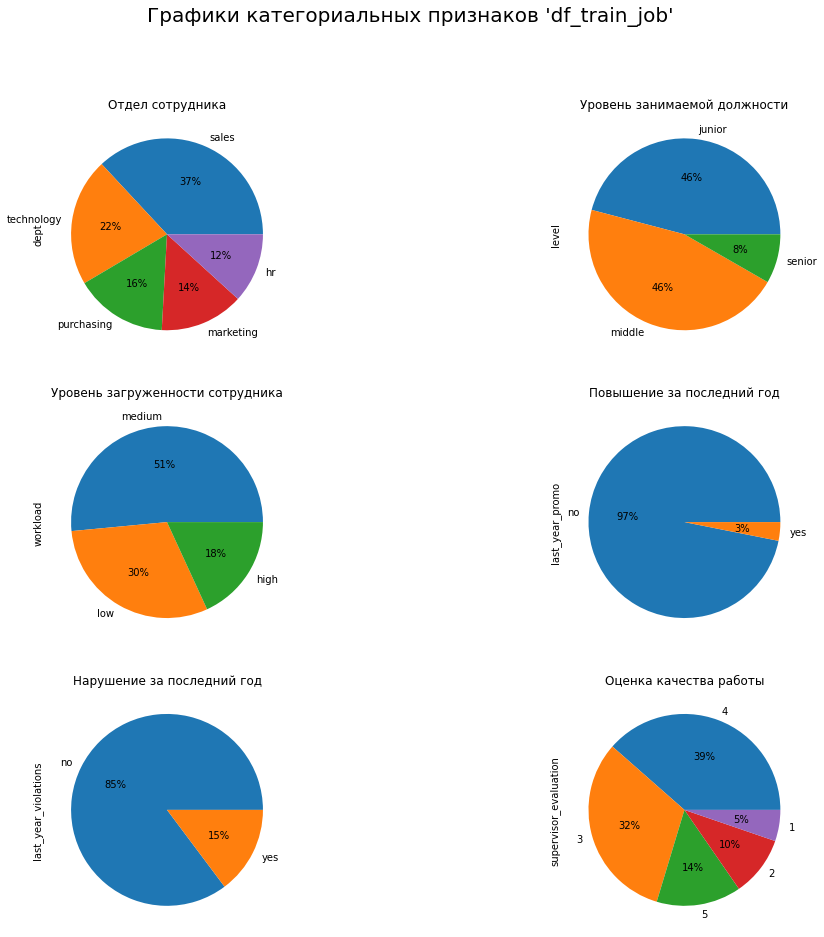

In [ ]:
plt.figure(figsize=(17, 15))
plt.suptitle('Графики категориальных признаков \'df_train_job\'', fontsize=20)

plt.subplot(3, 2, 1)
df_train_job['dept'].value_counts().plot(kind='pie', autopct='%1.0f%%', title='Отдел сотрудника')

plt.subplot(3, 2, 2)
df_train_job['level'].value_counts().plot(kind='pie', autopct='%1.0f%%', title='Уровень занимаемой должности')

plt.subplot(3, 2, 3)
df_train_job['workload'].value_counts().plot(kind='pie', autopct='%1.0f%%', title='Уровень загруженности сотрудника')

plt.subplot(3, 2, 4)
df_train_job['last_year_promo'].value_counts().plot(kind='pie', autopct='%1.0f%%', title='Повышение за последний год')

plt.subplot(3, 2, 5)
df_train_job['last_year_violations'].value_counts().plot(kind='pie', autopct='%1.0f%%', title='Нарушение за последний год');

plt.subplot(3, 2, 6)
df_train_job['supervisor_evaluation'].value_counts().plot(kind='pie', autopct='%1.0f%%', title='Оценка качества работы');

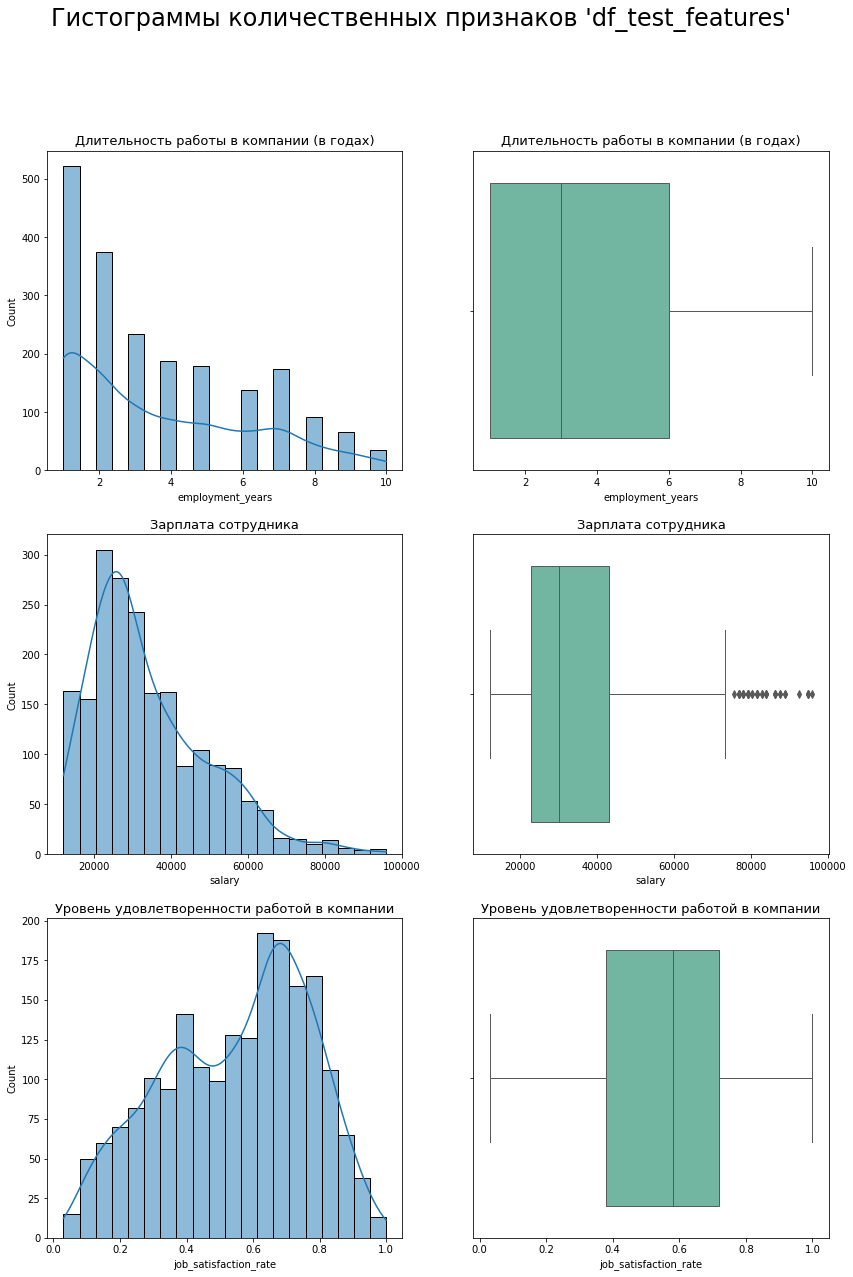

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(14, 20))

plt.suptitle('Гистограммы количественных признаков \'df_test_features\' ', fontsize=24)

axs[0][0].set_title('Длительность работы в компании (в годах)', fontsize=13)
sns.histplot(data=df_test_features, x='employment_years', ax=axs[0][0], kde=True, bins=20)

sns.boxplot(df_test_features['employment_years'], ax=axs[0][1], linewidth=1, palette='Set2', orient='h')
axs[0][1].set_title('Длительность работы в компании (в годах)', fontsize=13)

axs[1][0].set_title('Зарплата сотрудника', fontsize=13)
sns.histplot(data=df_test_features, x='salary', ax=axs[1][0], kde=True, bins=20)

sns.boxplot(df_test_features['salary'], ax=axs[1][1], linewidth=1, palette='Set2', orient='h')
axs[1][1].set_title('Зарплата сотрудника', fontsize=13)

axs[2][0].set_title('Уровень удовлетворенности работой в компании', fontsize=13)
sns.histplot(data=df_test_features, x='job_satisfaction_rate', ax=axs[2][0], kde=True, bins=20)

sns.boxplot(df_test_features['job_satisfaction_rate'], ax=axs[2][1], linewidth=1, palette='Set2', orient='h')
axs[2][1].set_title('Уровень удовлетворенности работой в компании', fontsize=13)

plt.show();

In [ ]:
Q1 = df_test_features['salary'].quantile(.25)
Q3 = df_test_features['salary'].quantile(.75)
IQR = Q3 - Q1

In [ ]:
(1-(df_test_features.query('salary < @Q3+1.5*@IQR and salary > @Q1-1.5*@IQR')['salary'].count()) / df_test_features['salary'].count()) * 100

1.9499999999999962

In [ ]:
df_test_features = df_test_features.query('salary < @Q3+1.5*@IQR and salary > @Q1-1.5*@IQR')

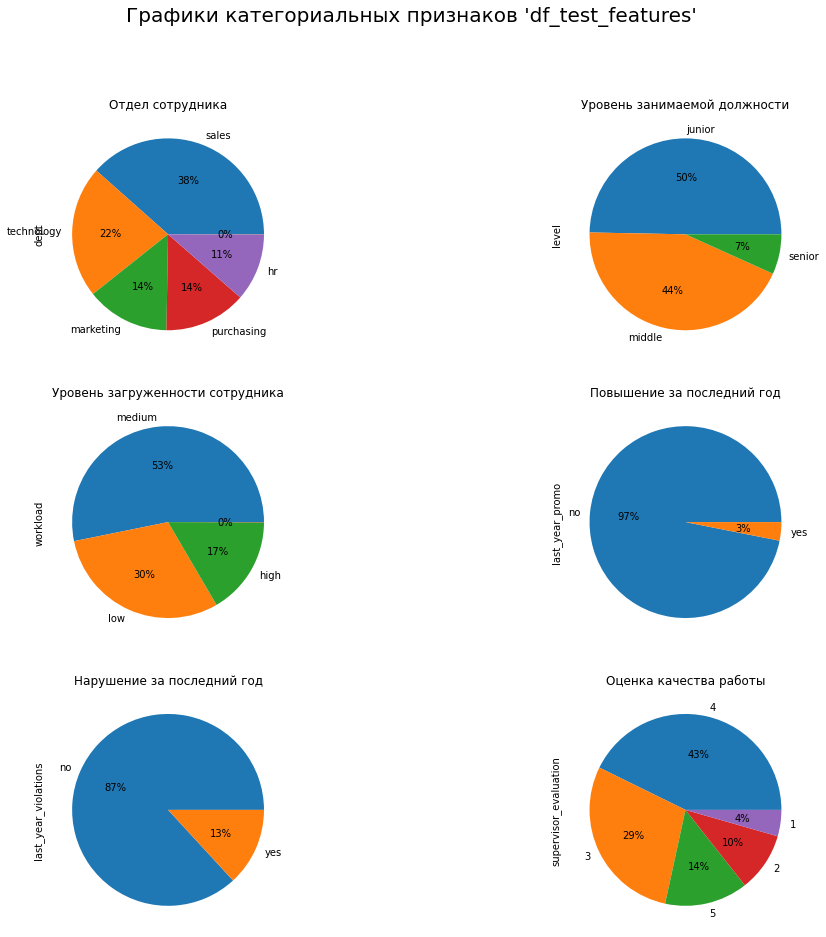

In [ ]:
plt.figure(figsize=(17, 15))
plt.suptitle('Графики категориальных признаков \'df_test_features\'', fontsize=20)

plt.subplot(3, 2, 1)
df_test_features['dept'].value_counts().plot(kind='pie', autopct='%1.0f%%', title='Отдел сотрудника')

plt.subplot(3, 2, 2)
df_test_features['level'].value_counts().plot(kind='pie', autopct='%1.0f%%', title='Уровень занимаемой должности')

plt.subplot(3, 2, 3)
df_test_features['workload'].value_counts().plot(kind='pie', autopct='%1.0f%%', title='Уровень загруженности сотрудника')

plt.subplot(3, 2, 4)
df_test_features['last_year_promo'].value_counts().plot(kind='pie', autopct='%1.0f%%', title='Повышение за последний год')

plt.subplot(3, 2, 5)
df_test_features['last_year_violations'].value_counts().plot(kind='pie', autopct='%1.0f%%', title='Нарушение за последний год');

plt.subplot(3, 2, 6)
df_test_features['supervisor_evaluation'].value_counts().plot(kind='pie', autopct='%1.0f%%', title='Оценка качества работы');

Проведем корелляционный анализ

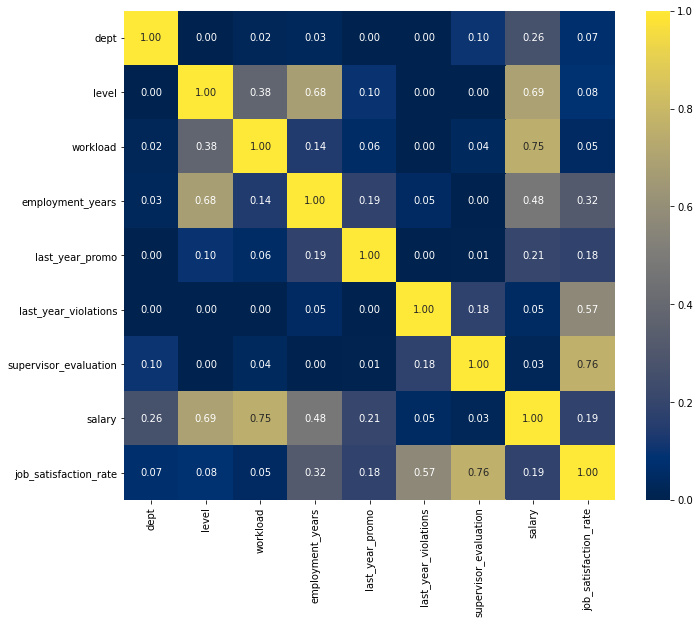

In [ ]:
plt.figure(figsize=(11, 9))
sns.heatmap(df_train_job.phik_matrix(interval_cols=['employment_years', 'salary', 'job_satisfaction_rate']),
            annot=True,
            cmap='cividis',
            fmt='.2f');

### Промежуточные выводы

Количественные признаки:

1. Зарплаты сотрудников имеют вид, близкий к распределению Пуассона с медианой в ~30000;
2. Уровень удовлетворенности работой напоминает нормальное распределение;
3. Длительность работы в компании имеет убывающую тенденцию - чем больше лет опыта, тем меньше сотрудников - это нормально;

Категориальные признаки:

1. Самые большие отделы - отделы продаж и технологий (около 60 % в сумме);
2. В компании около 46 % сотрудников - джуниоры, 46 % миддлы, и всего 8 % - сениоры;
3. Повышение получили только 3 % сотрудников;
4. Уровень загруженности в основном средний;
5. Нарушений за последний год - около 13 %.

Матрица корреляций:

Сильную корреляцию с целевым признаком имеет оценка руководителя (0.76). Также сильная связь между зарплатой и рабочей нагрузкой, уровнем занимаемой должности, ну и конечно уровень занимаемой должности зависит от опыта работы.

## Подготовка данных

In [ ]:
RANDOM_STATE = 42

In [ ]:
X_train = df_train_job.drop(['job_satisfaction_rate'], axis=1)
y_train = df_train_job['job_satisfaction_rate']

In [ ]:
X_test = df_test_features.drop(['id', 'job_satisfaction_rate'], axis=1)
y_test = df_test_features['job_satisfaction_rate']

In [ ]:
ohe_columns = ['last_year_promo', 'last_year_violations', 'dept']
ord_columns = ['workload', 'level']
num_columns = ['employment_years', 'salary', 'supervisor_evaluation']

In [ ]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

In [ ]:
ord_pipe = Pipeline(
    [
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['low', 'medium', 'high'],
                    ['junior', 'middle', 'senior'],
                ],
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [ ]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

## Обучение моделей

Функция для подсчета метрики SMAPE

In [ ]:
def smape(y_true, y_pred):
    assert len(y_true) == len(y_pred)

    n = len(y_true)
    sum_smape = np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

    smape_value = (1 / n) * sum_smape * 100

    return smape_value

smape_scorer = make_scorer(smape, greater_is_better=False)

In [ ]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

In [ ]:
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(25, 27),
        'models__max_features': range(26, 28),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [ ]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring=smape_scorer,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_ * -1)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations',
                                                   'dept']),
                                  

Лучшая метрика на тренировочной выборке - 14.99

In [ ]:
pipe_final.named_steps['preprocessor'].fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['last_year_promo', 'last_year_violations',
                                  'dept']),
                                ('ord',
                                 Pipeline(steps=[('ord',
                                                  OrdinalEncoder(categories=[['low',
                                                                              'medium',
                                                                              'high'],
                                                                             ['junior',
                                                                              'middle',
                                                                              'senior']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=nan)),
                                                 ('simpleImputer_after_ord',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['workload', 'level']),
                                ('num', StandardScaler(),
                                 ['employment_years', 'salary',
                                  'supervisor_evaluation'])])

In [ ]:
X_test_processed = pipe_final.named_steps['preprocessor'].transform(X_test)

In [ ]:
y_pred = randomized_search.best_estimator_[1].predict(X_test_processed)

In [ ]:
smape(y_test, y_pred)

14.440181756420344

## Выводы

Лучшей моделью оказалась DecisionTreeRegressor с гиперпараметрами max_depth=25, max_features=27 и random_state=42, данные были закодированы с помощью OrdinalEncoder и OneHotEncoder, масштабированы с помощью StandardScaler()

## Задача 2: предсказание увольнения сотрудника из компании

## Загрузка данных

In [ ]:
df_train_quit = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv', sep=',')
df_test_target = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv', sep=',')

In [ ]:
df_train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [ ]:
df_test_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [ ]:
df_train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [ ]:
df_test_target.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


## Предобработка данных

In [ ]:
df_train_quit.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

In [ ]:
df_test_target.isna().sum()

id      0
quit    0
dtype: int64

In [ ]:
df_train_quit['level'].unique()

array(['middle', 'junior', 'sinior'], dtype=object)

In [ ]:
df_train_quit = df_train_quit.replace({'sinior': 'senior'})

## Исследовательский анализ данных

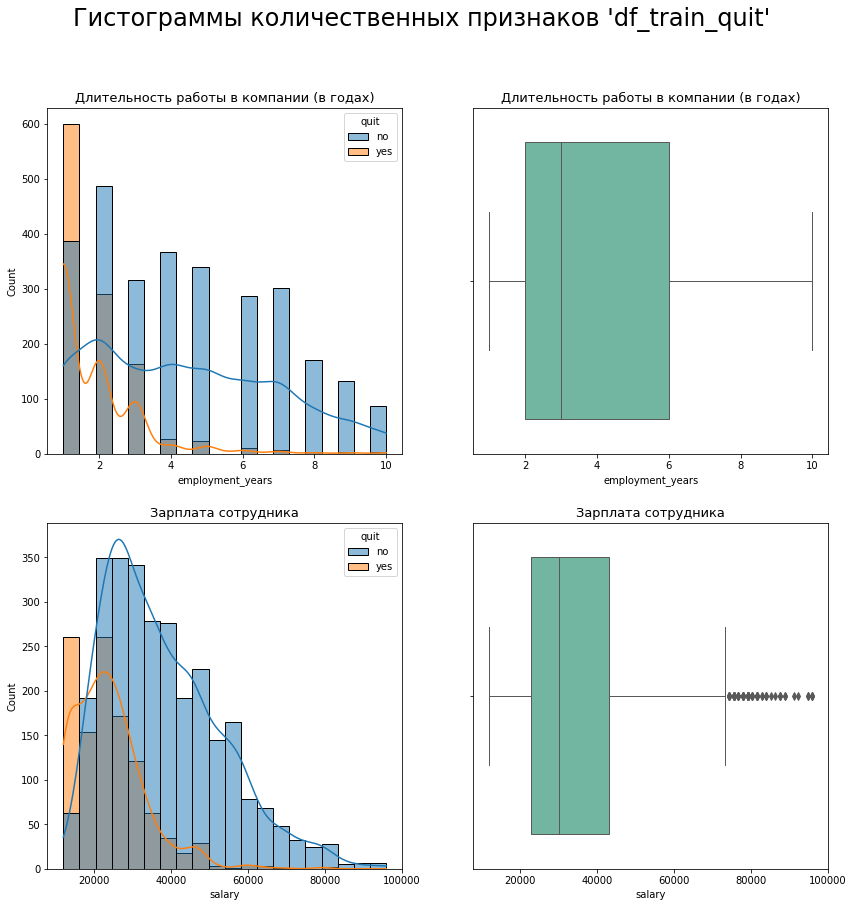

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(14, 14))

plt.suptitle('Гистограммы количественных признаков \'df_train_quit\' ', fontsize=24)

axs[0][0].set_title('Длительность работы в компании (в годах)', fontsize=13)
sns.histplot(data=df_train_quit, x='employment_years', hue='quit', ax=axs[0][0], kde=True, bins=20)

sns.boxplot(df_train_quit['employment_years'], ax=axs[0][1], linewidth=1, palette='Set2', orient='h')
axs[0][1].set_title('Длительность работы в компании (в годах)', fontsize=13)

axs[1][0].set_title('Зарплата сотрудника', fontsize=13)
sns.histplot(data=df_train_quit, x='salary', hue='quit', ax=axs[1][0], kde=True, bins=20)

sns.boxplot(df_train_quit['salary'], ax=axs[1][1], linewidth=1, palette='Set2', orient='h')
axs[1][1].set_title('Зарплата сотрудника', fontsize=13)

plt.show();

In [ ]:
Q1 = df_train_quit['salary'].quantile(.25)
Q3 = df_train_quit['salary'].quantile(.75)
IQR = Q3 - Q1

In [ ]:
(1-(df_train_quit.query('salary < @Q3+1.5*@IQR and salary > @Q1-1.5*@IQR')['salary'].count()) / df_train_quit['salary'].count()) * 100

1.9499999999999962

Удалим выбросы

In [ ]:
df_train_quit = df_train_quit.query('salary < @Q3+1.5*@IQR and salary > @Q1-1.5*@IQR')

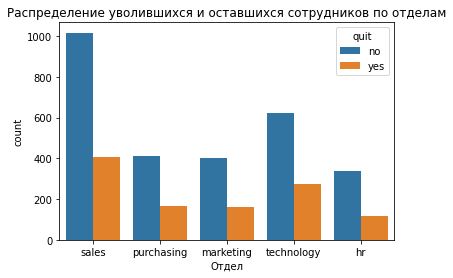

In [ ]:
sns.countplot(x='dept', hue='quit', data=df_train_quit)
plt.title('Распределение уволившихся и оставшихся сотрудников по отделам')
plt.xlabel('Отдел');

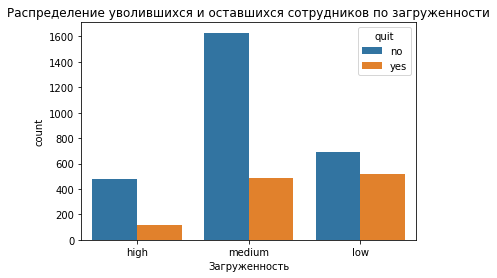

In [ ]:
sns.countplot(x='workload', hue='quit', data=df_train_quit)
plt.title('Распределение уволившихся и оставшихся сотрудников по загруженности')
plt.xlabel('Загруженность');

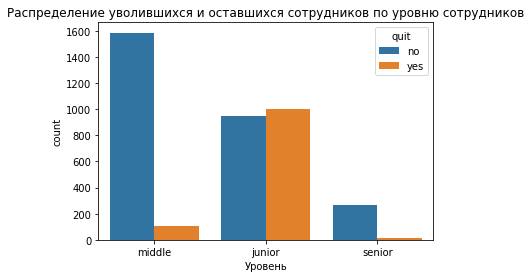

In [ ]:
sns.countplot(x='level', hue='quit', data=df_train_quit)
plt.title('Распределение уволившихся и оставшихся сотрудников по уровню сотрудников')
plt.xlabel('Уровень');

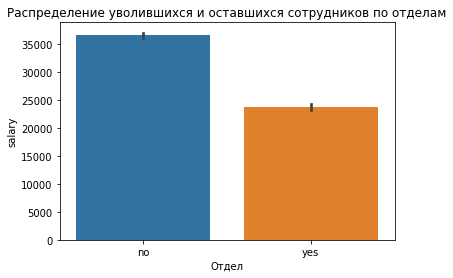

In [ ]:
sns.barplot(x='quit', y='salary', data=df_train_quit)
plt.title('Распределение уволившихся и оставшихся сотрудников по отделам')
plt.xlabel('Отдел');

### Портрет уволившегося сотрудника

Наиболее вероятно, что уволившийся сотрудник:
- из отдела продаж или технологий;
- с маленькой или средней нагрузкой;
- уровня junior;
- с зарплатой около 20000-25000

In [ ]:
test_features_data = pd.merge(df_test_features, df_test_target, on='id')

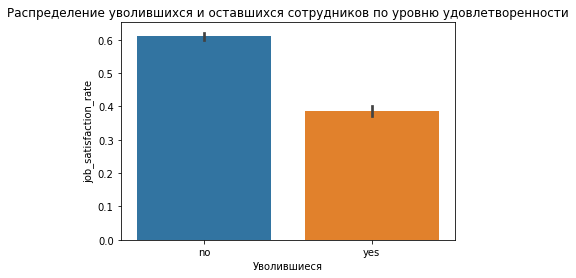

In [ ]:
sns.barplot(x='quit', y='job_satisfaction_rate', data=test_features_data)
plt.title('Распределение уволившихся и оставшихся сотрудников по уровню удовлетворенности')
plt.xlabel('Уволившиеся');

Уволившиеся сотрудники оценили работу в компании хуже, чем те, кто остался. Их средняя оценка ~ 0.4  

In [ ]:
dept_share = df_train_quit.groupby('dept')['quit'].value_counts(normalize=True).unstack().reset_index()

In [ ]:
dept_share = dept_share.reindex(columns=['dept', 'yes', 'no'])

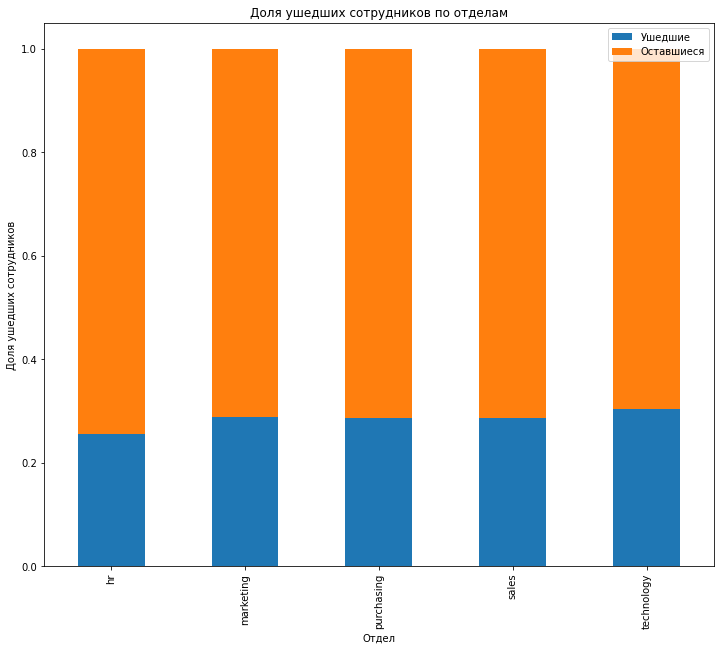

In [ ]:
dept_share.plot(x='dept', kind='bar', stacked=True, figsize=(12, 10))
plt.title('Доля ушедших сотрудников по отделам')
plt.xlabel('Отдел')
plt.ylabel('Доля ушедших сотрудников')
plt.legend(['Ушедшие', 'Оставшиеся'])

plt.show();

Как видим, из каждого отдела ушло не более 30 % от всех сотрудников

In [ ]:
level_share = df_train_quit.groupby('level')['quit'].value_counts(normalize=True).unstack().reset_index()

In [ ]:
level_share = level_share.reindex(columns=['level', 'yes', 'no'])

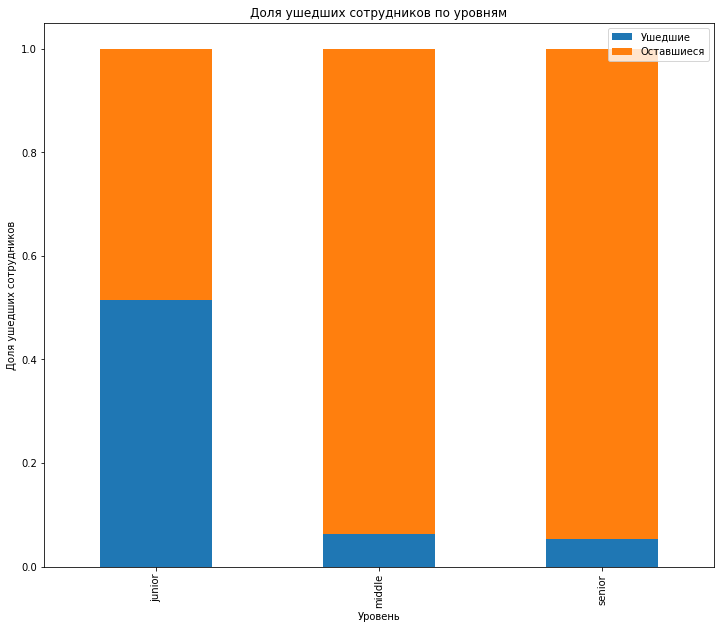

In [ ]:
level_share.plot(x='level', kind='bar', stacked=True, figsize=(12, 10))
plt.title('Доля ушедших сотрудников по уровням')
plt.xlabel('Уровень')
plt.ylabel('Доля ушедших сотрудников')
plt.legend(['Ушедшие', 'Оставшиеся'])

plt.show();

В основном, уволились джуниоры - около 50 %, уволившихся среди миддлов и сениоров меньше 10 %.

In [ ]:
workload_share = df_train_quit.groupby('workload')['quit'].value_counts(normalize=True).unstack().reset_index()

In [ ]:
workload_share = workload_share.reindex(columns=['workload', 'yes', 'no'])

In [ ]:
workload_share

quit,workload,yes,no
0,high,0.199330,0.800670
1,low,0.429636,0.570364
2,medium,0.230515,0.769485


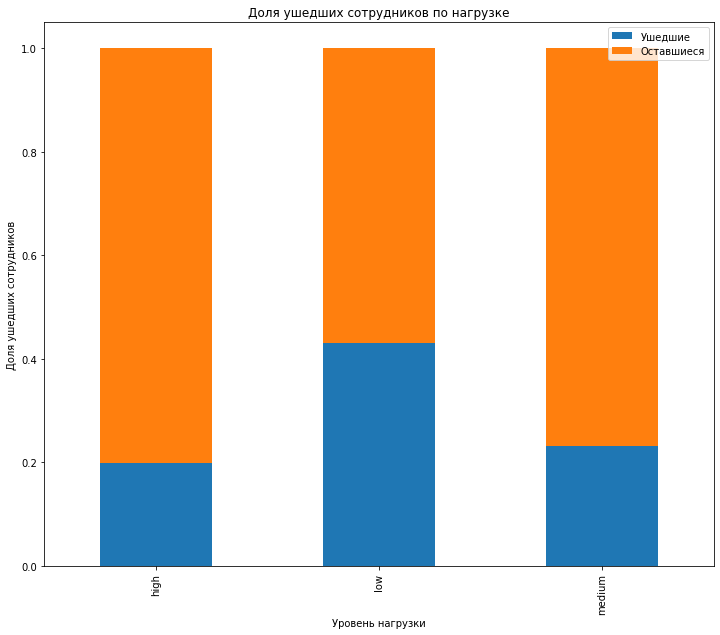

In [ ]:
workload_share.plot(x='workload', kind='bar', stacked=True, figsize=(12, 10))
plt.title('Доля ушедших сотрудников по нагрузке')
plt.xlabel('Уровень нагрузки')
plt.ylabel('Доля ушедших сотрудников')
plt.legend(['Ушедшие', 'Оставшиеся'])

plt.show();

Здесь же видно, что ушли в основном

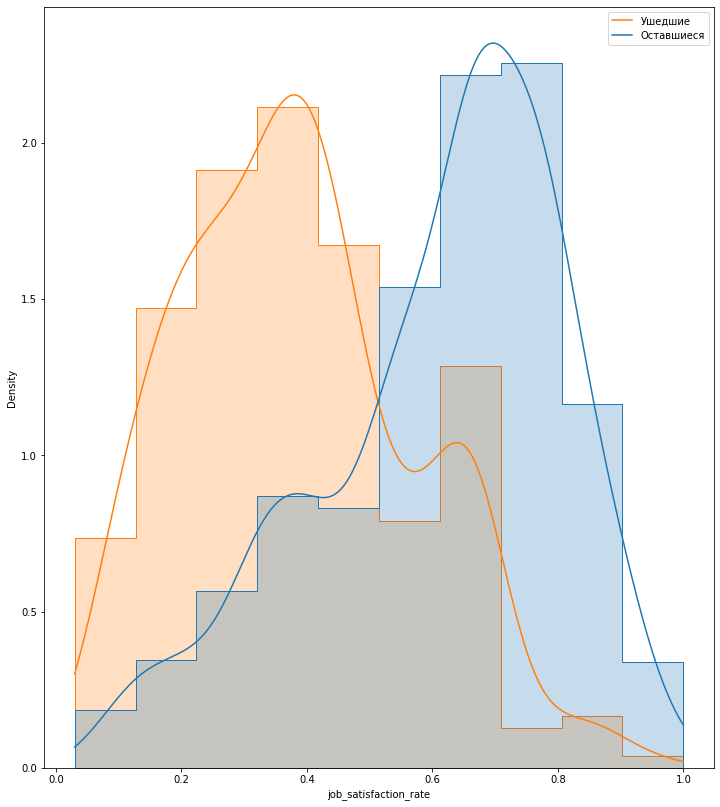

In [ ]:
plt.figure(figsize=(12, 14))
sns.histplot(test_features_data, x='job_satisfaction_rate', hue='quit', kde=True, bins=10, element="step", stat="density", common_norm=False)
plt.legend(['Ушедшие', 'Оставшиеся']);

В основном, уволившиеся оценивали работу в компании ниже, чем оставшиеся. Основное распределение оценок уволившихся приходится на 0.2-0.6, тогда как у оставшихся 0.5-0.9

## Добавление нового входного признака

Добавим признак в тренировочную выборку

In [ ]:
train_quit_data = df_train_quit.drop(['id', 'quit'], axis=1)

In [ ]:
train_quit_data_transformed = pipe_final.named_steps['preprocessor'].transform(train_quit_data)

In [ ]:
pred_satisfaction = randomized_search.best_estimator_[1].predict(train_quit_data_transformed)

In [ ]:
df_train_quit['predicted_satisfaction'] = pred_satisfaction

И в тестовую

In [ ]:
test_features_data['predicted_satisfaction'] = y_pred

## Подготовка данных

In [ ]:
X_train_quit = df_train_quit.drop(['id', 'quit'], axis=1)
y_train_quit = df_train_quit['quit']

In [ ]:
X_test_quit = test_features_data.drop(['id', 'quit', 'job_satisfaction_rate'], axis=1)
y_test_quit = test_features_data['quit']

Вся остальная часть у нас уже сохранена в первом задании

## Обучение модели

In [ ]:
param_grid_2 = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(5, 10),
        'models__max_features': range(6, 8),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [ ]:
grid_search = GridSearchCV(
    pipe_final,
    param_grid_2,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
grid_search.fit(X_train_quit, y_train_quit)

print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations',
                                                   'dept']),
                                  

Трансформируем все данные

In [ ]:
pipe_final.named_steps['preprocessor'].fit(X_train_quit)

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['last_year_promo', 'last_year_violations',
                                  'dept']),
                                ('ord',
                                 Pipeline(steps=[('ord',
                                                  OrdinalEncoder(categories=[['low',
                                                                              'medium',
                                                                              'high'],
                                                                             ['junior',
                                                                              'middle',
                                                                              'senior']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=nan)),
                                                 ('simpleImputer_after_ord',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['workload', 'level']),
                                ('num', StandardScaler(),
                                 ['employment_years', 'salary',
                                  'supervisor_evaluation'])])

In [ ]:
X_test_quit_processed = pipe_final.named_steps['preprocessor'].transform(X_test_quit)

In [ ]:
y_pred_quit = grid_search.best_estimator_[1].predict_proba(X_test_quit_processed)[:,1]

In [ ]:
roc_auc_score(y_test_quit, y_pred_quit)

0.9281894576012223

Наша метрика составила 0.93 - результат соответствует поставленной цели

## Выводы

Лучшей моделью оказалась DecisionTreeClassifier() с max_depth=5, max_features=6 и random_state=42. Такие параметры помогают предотвратить переобучение

roc_auc_score = 0.92 говорит о высоком качестве модели в предсказании увольнения сотрудника.
МетриаC близка к 1, что свидетельствует о хорошей способности модели различать между классами.

## Общий вывод

Нам предоставили 2 задачи:

1. Предсказание уровня удовлетворённости сотрудника (датасеты с целевым признаком `job_satisfaction_rate`)
2. Предсказание увольнения сотрудника из компании (датасеты с целевым признаком `quit`)

Выполнив предобработку данных, исследовав их, мы обнаружили пропущенные значения, дубликаты и выбросы, после чего, устранили их.

Подготовили данные с помощью пайплайнов, использовали OneHotEncoder и OrdinalEncoder, а также StandardScaler и MinMaxScaler().

Обучили модель и посчитали метрику на тренировочных и тестовых данных. Они соответствуют задаче.

**Рекомендации:**
Судя по графикам, чаще всего увольнялись сотрудники уровня junior с маленькой нагрузкой. Причем среди уволившихся чаще всего уровень удовлетворенности работой меньше 0.5. Возможно, это было связано, маленькой зарплатой, стоит обратить на это внимание.

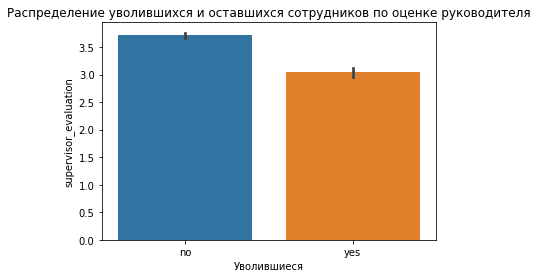

In [ ]:
sns.barplot(x='quit', y='supervisor_evaluation', data=test_features_data)
plt.title('Распределение уволившихся и оставшихся сотрудников по оценке руководителя')
plt.xlabel('Уволившиеся');

Тут же можно заметить, что уволившиеся в среднем работают на "троечку".

Бизнесу нужно использовать эту модель для выявления сотрудников с высоким риском увольнения и для улучшения удовлетворённости и удержания ключевых сотрудников.

Возможно, для удержания следует акцентировать внимание на следующих шагах:

- Предоставление персонализированных программ обучения и развития в соответствии с потребностями сотрудников;
- Ииндивидуальные планы карьерного роста и развития.